In [1]:
####################################################
## Hurricane Ida Analysis                         ##
## @brett | 09-05-2021                            ##
####################################################

# Getting Data Ready

In [8]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# Change some settings
pd.options.display.max_rows = 999

# Import Data
last_year = pd.read_csv('./../data/Calls_for_service_2020.csv')
this_year = pd.read_csv('./../data/Calls_for_service_2021.csv')

# Merge into one dataset
data = this_year.append(last_year).reset_index().drop('index',axis=1)

In [9]:
# This cleans the date, if there is no date there, I fill in a date from 1900 so that I can easily filter it out
def clean_date(s):
    try:
        return(datetime.strptime(s,'%m/%d/%Y %I:%M:%S %p'))
    except:
        return(None)

In [10]:
# Let's clean up some of these fun timestamps
data['DateCreate'] = data['TimeCreate'].apply(lambda x: datetime.strptime(x[:10],'%m/%d/%Y'))
data['TimeCreate'] = data['TimeCreate'].apply(lambda x: clean_date(x))
data['TimeDispatch'] = data['TimeDispatch'].apply(lambda x: clean_date(x))
data['TimeArrive'] = data['TimeArrive'].apply(lambda x: clean_date(x))
data['TimeClosed'] = data['TimeClosed'].apply(lambda x: clean_date(x))

In [26]:
day_counts = data[['DateCreate', 'TimeCreate']].groupby('DateCreate').count().reset_index()

In [27]:
day_counts.columns = ['date', 'count']

[Text(0, 0.5, 'count of incidents')]

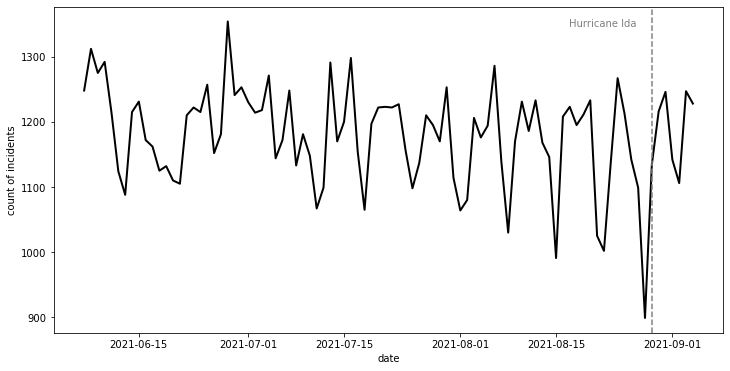

In [85]:
fig,ax = plt.subplots(figsize = (12,6))
sns.lineplot(x="date", y="count",
             data=day_counts[-90:], color='black', linewidth=2)
ax.axvline(datetime.strptime('20210829','%Y%m%d'), color='grey', linestyle='--')
ax.text(0.82, 0.95,'Hurricane Ida',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes, color='grey')
ax.set(ylabel='count of incidents',)

In [39]:
# Looks like it is an anomaly for how low it is on the day before the hurricane...I wonder why

In [42]:
day_counts

,date,count
0,2020-01-01,1324
1,2020-01-02,1166
2,2020-01-03,1112
3,2020-01-04,1134
4,2020-01-05,1159
5,2020-01-06,1173
6,2020-01-07,1183
7,2020-01-08,1238
8,2020-01-09,1323
9,2020-01-10,1240


In [40]:
day_counts.min()

date     2020-01-01 00:00:00
count                    899
dtype: object